In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

# 0. Folder creation

In [2]:
%%bash
#Structured mesh should be on str_uns/structuredMesh 

#Main conversion directory
if [ ! -d "str_uns" ]; then
  mkdir str_uns
fi

#It should ensure that the structured mesh exists
if [ ! -d "str_uns/structuredMesh" ]; then
    echo "NON STRUCTURED MESH to convert"
    exit 0
fi

#If the directory of a previous unstructured mesh exists it will remove
if [ -d "str_uns/unstructuredMesh" ]; then
  rm str_uns/unstructuredMesh -r
  cp str_uns/structuredMesh str_uns/unstructuredMesh -r
fi

#If the directory does not exists
if [ ! -d "str_uns/unstructuredMesh" ]; then
  cp str_uns/structuredMesh str_uns/unstructuredMesh -r
fi

# 1. Data input - point adquisition

In [3]:
filename = './str_uns/structuredMesh/constant/polyMesh/points'
file = open(filename, "r")
points_str = file.read()

i = 2
pointsNo = 0

while points_str[points_str.find('(')-i] != '\n':
    pointsNo = pointsNo * 10 + int(points_str[points_str.find('(')-i])
    i += 1
    
print(pointsNo)
    
points = np.zeros((pointsNo, 3))

242


In [4]:
arrayPos = 0
tempPos = 0
negVal = 0
decimal = 0

for i in range(points_str.find('(')+1, len(points_str)):
    #First element of each line resets the temporal points
    if points_str[i] == '(':
        tempPoints = np.zeros(3)
    #End element of each line transfer the elements to the big array, resets tempPos and advance 1 in arrayPos
    elif points_str[i] == ')':
        points[arrayPos,:] = tempPoints
        arrayPos += 1
        tempPos = 0
    #An space will do nothing for the moment!
    elif points_str[i] == ' ' :
        pass;
    #New line will do nothing! - except if it arrives to the end of the string it will encounter ) \n ) 
    elif points_str[i] == '\n':
        if points_str[i-1] == ')' and points_str[i] == '\n' and points_str[i+1] == ')':
            break;
    #Minus sign will do nothing (for the moment!)
    elif points_str[i] == '-':
        negVal = 1
    #Period will do nothing (for the moment!)
    elif points_str[i] == '.':
        decimal = 1;
    #If the element is a number...
    else:
        #if it is zero we are still on the natural part of the number
        if decimal == 0:    
            tempPoints[tempPos] = 10*tempPoints[tempPos]+int(points_str[i])
        #if the decimal variable is not zero
        if decimal >= 1:
            #If the next element of the string is a space or a ), the number will be completed
            if points_str[i+1] == ' ' or points_str[i+1] == ')':
                tempPoints[tempPos] = tempPoints[tempPos]+int(points_str[i])*10**(-decimal)
                decimal = 0
            #If it is a number
            else: 
                tempPoints[tempPos] = tempPoints[tempPos]+int(points_str[i])*10**(-decimal)
                decimal += 1
        #If the next element is a space...
        if points_str[i+1] == ' ' :
            #... and a negative sign was found, it should multiply now by -1 and advance one position...
            if negVal == 1:
                tempPoints[tempPos] *= -1
                tempPos += 1
                negVal = 0
            #... otherwise it will just advance one position
            else:
                tempPos += 1

# 2. Grid conversion

In [5]:
#Comparison of the points from the two sets: front and back plane (to make points meet)
np.array_equal(points[:int(len(points)/2),0:1], points[int(len(points)/2):,0:1])

True

In [6]:
#Bounding box to perform the unstructured grid - if other one is wanted, please specify!!
Xmax = np.max(points[:,0])
Xmin = np.min(points[:,0])
Ymax = np.max(points[:,1])
Ymin = np.min(points[:,1])

#Xmax = 
#Xmin = 
#Ymax = 
#Ymin = 

#Distance factor to restrict the maximum displacement of the points [0,1]
k = 0.4

unstrPoints = np.zeros(np.shape(points))

In [7]:
for i in range(int(len(points)/2)):
    #If the point is between bounds
    if points[i,0] > Xmin and points[i,0] < Xmax and points[i,1] > Ymin and points[i,1] < Ymax:
        #neighbor points of the i-th point should be computed: x-axis neighbors are easy (+i and -i)
        #for the y-axis a distance matrix will be computed for each i-th case, for the minimum distance at the point i
        upperY = np.argmin(np.sqrt((points[i+2:int(len(points)/2),0]-points[i,0])**2+(points[i+2:int(len(points)/2),1]-points[i,1])**2))+2+i
        lowerY = np.argmin(np.sqrt((points[:i-2,0]-points[i,0])**2+(points[:i-2,1]-points[i,1])**2))
        #it must vary the same in the front and back plane, so a temporal variable is created
        varX = np.random.triangular(-abs(points[i-1,0]-points[i,0]), 0, abs(points[i+1,0]-points[i,0]), 1)
        varY = np.random.triangular(-abs(points[lowerY,1]-points[i,1]), 0, abs(points[upperY,1]-points[i,1]), 1)
        #Let's store the points in the array
        unstrPoints[i,0] = points[i,0]+k*varX
        unstrPoints[i,1] = points[i,1]+k*varY
        unstrPoints[i,2] = points[i,2]
        unstrPoints[int(len(points)/2)+i,0] = points[i,0]+k*varX
        unstrPoints[int(len(points)/2)+i,1] = points[i,1]+k*varY
        unstrPoints[int(len(points)/2)+i,2] = points[int(len(points)/2)+i,2]
    else:
        unstrPoints[i,0] = points[i,0]
        unstrPoints[i,1] = points[i,1]
        unstrPoints[i,2] = points[i,2]
        unstrPoints[int(len(points)/2)+i,0] = points[i,0]
        unstrPoints[int(len(points)/2)+i,1] = points[i,1]
        unstrPoints[int(len(points)/2)+i,2] = points[int(len(points)/2)+i,2]

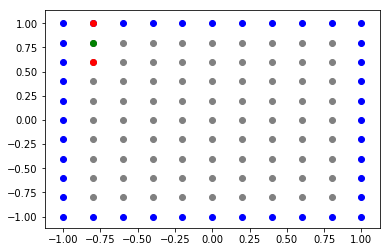

In [8]:
#above and below points
for i in range(int(len(points)/2)):
    if points[i,0] > Xmin and points[i,0] < Xmax and points[i,1] > Ymin and points[i,1] < Ymax:
        plt.scatter(points[i,0],points[i,1],color='grey')
    else:
        plt.scatter(points[i,0],points[i,1],color='blue')

i = 100
plt.scatter(points[i,0],points[i,1],color='g')
plt.scatter(points[np.argmin(np.sqrt((points[:i-2,0]-points[i,0])**2+(points[:i-2,1]-points[i,1])**2)),0],points[np.argmin(np.sqrt((points[:i-2,0]-points[i,0])**2+(points[:i-2,1]-points[i,1])**2)),1],color='r')
plt.scatter(points[np.argmin(np.sqrt((points[i+2:int(len(points)/2),0]-points[i,0])**2+(points[i+2:int(len(points)/2),1]-points[i,1])**2))+2+i,0],points[np.argmin(np.sqrt((points[i+2:int(len(points)/2),0]-points[i,0])**2+(points[i+2:int(len(points)/2),1]-points[i,1])**2))+2+i,1],color='r')

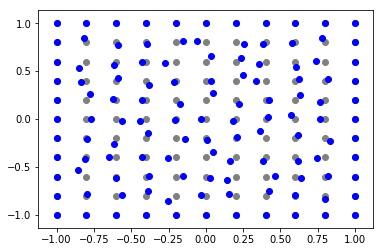

In [9]:
#Final result demonstration
plt.scatter(points[:121,0],points[:121,1],color='grey')
plt.scatter(unstrPoints[:121,0],unstrPoints[:121,1],color='blue')


In [10]:
#Both sets (front and back) must be the same as before
np.array_equal(unstrPoints[:int(len(unstrPoints)/2),0:1], unstrPoints[int(len(unstrPoints)/2):,0:1])

True

# 3. Point saving

In [11]:
%%bash
rm ./str_uns/unstructuredMesh/constant/polyMesh/points
rm ./str_uns/unstructuredMesh/constant/polyMesh/str_uns -r

rm: cannot remove './str_uns/unstructuredMesh/constant/polyMesh/str_uns': No such file or directory


In [12]:
with open('./str_uns/unstructuredMesh/constant/polyMesh/points', 'a') as uPF: #unstructuredPointFile
    uPF.write('/*--------------------------------*- C++ -*----------------------------------*\ \n')
    uPF.write('| =========                 |                                                 | \n')
    uPF.write('| \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox           | \n')
    uPF.write('|  \\    /   O peration     | Version:  5.x                                   | \n')
    uPF.write('|   \\  /    A nd           | Web:      www.OpenFOAM.org                      | \n')
    uPF.write('|    \\/     M anipulation  |                                                 | \n')
    uPF.write('\*---------------------------------------------------------------------------*/ \n')
    uPF.write('FoamFile \n')
    uPF.write('{ \n')
    uPF.write('    version     2.0; \n')
    uPF.write('    format      ascii; \n')
    uPF.write('    class       vectorField; \n')
    uPF.write('    location    "constant/polyMesh"; \n')
    uPF.write('    object      points; \n')
    uPF.write('} \n')
    uPF.write('// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * // \n')
    uPF.write('\n')
    uPF.write('%i \n' %(pointsNo))
    uPF.write('(')
    for i in range(pointsNo):
        uPF.write('(%.6f %.6f %.6f) \n' %(unstrPoints[i,0], unstrPoints[i,1], unstrPoints[i,2]))        
    uPF.write(')')